In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.image as mpimg
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau

# Import Densenet from Keras
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

In [8]:
trdata = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    #zoom_range = 0.2,
    #horizontal_flip = True,
    #fill_mode= 'nearest',

)
traindata = trdata.flow_from_directory('/content/drive/Shareddrives/Thenerdone/Dataset B PM/Train',
                                       target_size=(224,224),
                                       batch_size=32,
                                       class_mode='categorical',
                                       shuffle=True,
                                    )
tsdata = ImageDataGenerator(rescale=1./255)
testdata = tsdata.flow_from_directory('/content/drive/Shareddrives/Thenerdone/Dataset B PM/Test',
                                      target_size=(224,224),
                                      batch_size=32,
                                      class_mode='categorical',
                                      shuffle=False,
                                    )

Found 1500 images belonging to 3 classes.
Found 800 images belonging to 3 classes.


In [9]:
traindata.class_indices

{'Covid-19': 0, 'Normal': 1, 'Pneumonia': 2}

In [10]:
testdata.class_indices

{'Covid-19': 0, 'Normal': 1, 'Pneumonia': 2}

In [11]:
# Create the base pre-trained model
base_model = DenseNet121(weights='/content/drive/Shareddrives/Thenerdone/Weights Coursera/Coursera.hdf5', include_top=False) 

In [16]:
# Print the model summary
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

In [17]:
base_model.trainable = False

In [18]:
x = base_model.output
x

<KerasTensor: shape=(None, None, None, 1024) dtype=float32 (created by layer 'relu')>

In [15]:
x = Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3))(x)
x = Conv2D(64,(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(64,(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

x = Conv2D(128,(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.25)(x)

#x = Flatten()(x)
#x = Dense(64,activation='relu')(x)
#x = Dense(1,activation='sigmoid')(x

In [19]:

x = Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu")(x)
x = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
'''
x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
'''
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
#x = Dropout(0.25)(x)
'''
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
'''

'\nx = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)\n\nx = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)\n'

In [20]:
#x=Conv2D(128,(3,3),activation='relu')(x)

In [21]:
# Add a global spatial average pooling layer
x_pool = GlobalAveragePooling2D()(x)
x_pool

<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'global_average_pooling2d')>

In [22]:
predictions = Dense(3, activation="softmax")(x_pool)

In [23]:
model = Model(inputs=base_model.input, outputs=predictions)

In [24]:
# Compile the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])
# (You'll customize the loss function in the assignment!)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                           

In [26]:
hist = model.fit(
    traindata,
    #steps_per_epoch=50,
    epochs=10,
    validation_data=testdata,
    validation_steps=2,
    #callbacks = [learning_rate_reduction]
)

Epoch 1/10
47/47 [==============================] - 798s 17s/step - loss: 0.5213 - accuracy: 0.7840 - val_loss: 0.1042 - val_accuracy: 0.9688
Epoch 2/10
47/47 [==============================] - 30s 634ms/step - loss: 0.2453 - accuracy: 0.9220 - val_loss: 0.0883 - val_accuracy: 0.9844
Epoch 3/10
47/47 [==============================] - 30s 628ms/step - loss: 0.2182 - accuracy: 0.9300 - val_loss: 0.0916 - val_accuracy: 0.9844
Epoch 4/10
47/47 [==============================] - 29s 621ms/step - loss: 0.1746 - accuracy: 0.9473 - val_loss: 0.3326 - val_accuracy: 0.9375
Epoch 5/10
47/47 [==============================] - 29s 621ms/step - loss: 0.1792 - accuracy: 0.9420 - val_loss: 0.0670 - val_accuracy: 0.9844
Epoch 6/10
47/47 [==============================] - 29s 625ms/step - loss: 0.1323 - accuracy: 0.9580 - val_loss: 0.1123 - val_accuracy: 0.9844
Epoch 7/10
47/47 [==============================] - 29s 624ms/step - loss: 0.1237 - accuracy: 0.9580 - val_loss: 0.2277 - val_accuracy: 0.9375


In [42]:
tsdata = ImageDataGenerator(rescale=1./255)
testdata = tsdata.flow_from_directory('/content/drive/Shareddrives/Thenerdone/Dataset A(3k Small)/Test',
                                      target_size=(224,224),
                                      batch_size=32,
                                      class_mode='categorical',
                                      shuffle=False,
                                    )

Found 300 images belonging to 3 classes.


In [43]:
model.evaluate(traindata)

47/47 [==============================] - 29s 612ms/step - loss: 0.1257 - accuracy: 0.9567


[0.12568996846675873, 0.9566666483879089]

In [44]:
model.evaluate(testdata)

10/10 [==============================] - 92s 10s/step - loss: 5.5052 - accuracy: 0.6633


[5.505222797393799, 0.6633333563804626]

In [45]:
p = model.predict(testdata)

In [46]:
pred_classes = np.argmax(p, axis=1)

In [47]:
pred_classes

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0])

In [48]:
true_classes = testdata.classes

In [49]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d

In [50]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
cm = confusion_matrix(true_classes,pred_classes)
cm

array([[97,  0,  3],
       [ 0, 99,  1],
       [92,  5,  3]])

In [52]:
cmn=cm/cm.astype(np.float).sum(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
labels=['Covid-19','Normal','Pneumonia']

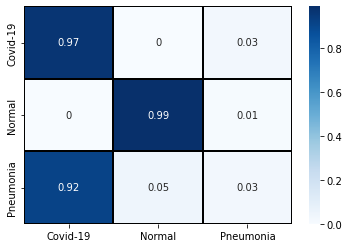

In [55]:
sns.heatmap(cmn,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True,xticklabels = labels,yticklabels = labels)

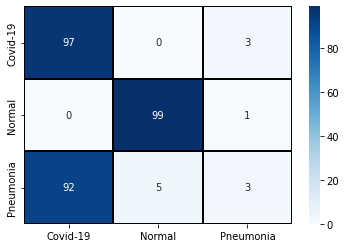

In [56]:
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True,xticklabels = labels,yticklabels = labels)

In [57]:
print(classification_report(true_classes,pred_classes, target_names = ['Covid-19 (Class 0)' ,'Normal (Class 1)','Pneumonia (Class 2)',]))

                     precision    recall  f1-score   support

 Covid-19 (Class 0)       0.51      0.97      0.67       100
   Normal (Class 1)       0.95      0.99      0.97       100
Pneumonia (Class 2)       0.43      0.03      0.06       100

           accuracy                           0.66       300
          macro avg       0.63      0.66      0.57       300
       weighted avg       0.63      0.66      0.57       300



In [73]:
model1=load_model("/content/drive/Shareddrives/Thenerdone/Models/Ex-7 (4.2.1) double-1,3 block DenseNet (PM).md5")

In [58]:
tsdata = ImageDataGenerator(rescale=1./255)
testdata = tsdata.flow_from_directory('/content/drive/Shareddrives/Thenerdone/Dataset C/Test',
                                      target_size=(224,224),
                                      batch_size=32,
                                      class_mode='categorical',
                                      shuffle=False,
                                    )

Found 300 images belonging to 3 classes.


In [74]:
p = model1.predict(testdata)

In [75]:
pred_classes = np.argmax(p, axis=1)

In [76]:
pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [77]:
true_classes = testdata.classes

In [78]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d

In [79]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [80]:
cm = confusion_matrix(true_classes,pred_classes)
cm

array([[97,  2,  1],
       [84, 13,  3],
       [98,  1,  1]])

In [81]:
cmn=cm/cm.astype(np.float).sum(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
labels=['Covid-19','Normal','Pneumonia']

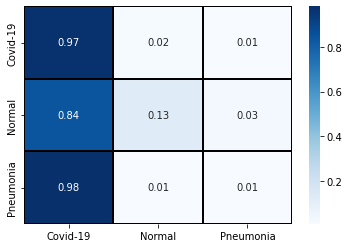

In [84]:
sns.heatmap(cmn,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True,xticklabels = labels,yticklabels = labels)

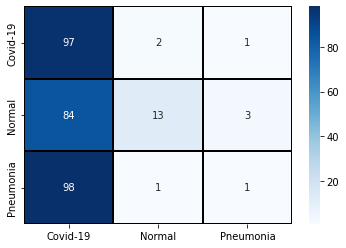

In [85]:
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True,xticklabels = labels,yticklabels = labels)

In [86]:
print(classification_report(true_classes,pred_classes, target_names = ['Covid-19 (Class 0)' ,'Normal (Class 1)','Pneumonia (Class 2)',]))

                     precision    recall  f1-score   support

 Covid-19 (Class 0)       0.35      0.97      0.51       100
   Normal (Class 1)       0.81      0.13      0.22       100
Pneumonia (Class 2)       0.20      0.01      0.02       100

           accuracy                           0.37       300
          macro avg       0.45      0.37      0.25       300
       weighted avg       0.45      0.37      0.25       300



In [87]:

model.save("/content/drive/Shareddrives/Thenerdone/Models/Ex-13 NIH Dataset A DenseNet 3k.md5")

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Thenerdone/Models/Ex-13 NIH Dataset A DenseNet 3k.md5/assets


In [88]:
model2=load_model("/content/drive/Shareddrives/Thenerdone/Models/Ex-2 double-2,3 block DenseNet 3k.md5")

In [89]:
tsdata = ImageDataGenerator(rescale=1./255)
testdata = tsdata.flow_from_directory('/content/drive/Shareddrives/Thenerdone/Dataset 2/Test',
                                      target_size=(224,224),
                                      batch_size=32,
                                      class_mode='categorical',
                                      shuffle=False,
                                    )

Found 245 images belonging to 3 classes.


In [91]:
p = model2.predict(testdata)

In [92]:
pred_classes = np.argmax(p, axis=1)

In [93]:
pred_classes

array([0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 2,
       0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 2,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 2, 2, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1,
       1, 1, 2])

In [94]:
true_classes = testdata.classes

In [95]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2], dtype=int32)

In [96]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [97]:
cm = confusion_matrix(true_classes,pred_classes)
cm

array([[35,  1,  9],
       [ 0, 98,  2],
       [33, 57, 10]])

In [107]:
#cmn=cm/cm.astype(np.float).sum(axis=1)
cmn = cm / np.sum(cm, axis=1, keepdims=True)

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
labels=['Covid-19','Normal','Pneumonia']

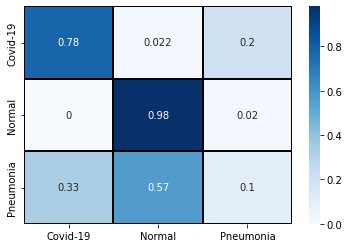

In [110]:
sns.heatmap(cmn,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True,xticklabels = labels,yticklabels = labels)

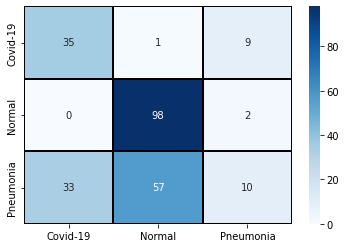

In [111]:
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True,xticklabels = labels,yticklabels = labels)

In [103]:
print(classification_report(true_classes,pred_classes, target_names = ['Covid-19 (Class 0)' ,'Normal (Class 1)','Pneumonia (Class 2)',]))

                     precision    recall  f1-score   support

 Covid-19 (Class 0)       0.51      0.78      0.62        45
   Normal (Class 1)       0.63      0.98      0.77       100
Pneumonia (Class 2)       0.48      0.10      0.17       100

           accuracy                           0.58       245
          macro avg       0.54      0.62      0.52       245
       weighted avg       0.55      0.58      0.49       245



In [ ]:
IMAGES_PATH="/content/drive/Shareddrives/Thenerdone/BRAC TB Hospital Nilphamari"

In [ ]:
image_names = os.listdir(IMAGES_PATH)

In [ ]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor



In [ ]:
for i in os. listdir(IMAGES_PATH):
    # load a single image
    new_image = load_image(IMAGES_PATH+"/"+i)

    # check prediction
    p = model.predict(new_image)
    pred_classes = np.argmax(p, axis=1)
    print( pred_classes)

[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]
[2]


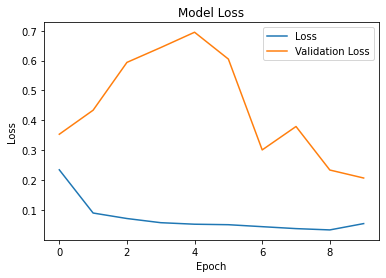

In [ ]:
#plt.plot(M.history['accuracy'])
#plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss','Validation Loss'])
plt.show()

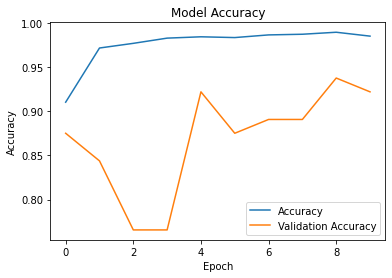

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
#plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy','Validation Accuracy'])
plt.show()

In [ ]:
model.summary()

In [ ]:
model=load_model("/content/drive/Shareddrives/Thenerdone/Models/Ex-5 IMGNET True DenseNet 3k.md5")

OSError: ignored

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

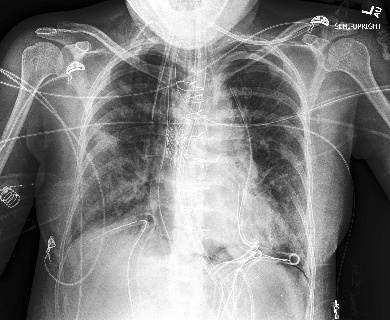

In [ ]:
model_builder = model
img_size = (224, 224)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_4"

# The local path to our target image
img_path = "/content/drive/Shareddrives/Thenerdone/ChexPert - Covid 3k+/Test2/Pneumonia/Pneumonia1005.jpeg"

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted: [[  0.29387423 -19.018137    15.915838  ]]


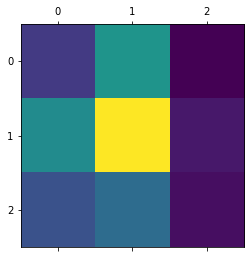

In [ ]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

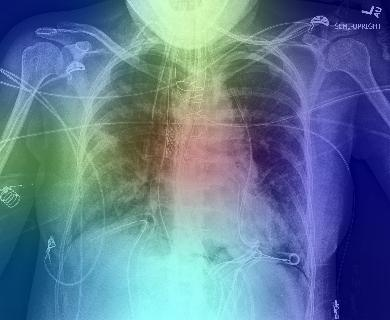

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.7):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)